<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignment 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [10]:
##### Your Code Here #####

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow, Keras, NN stuff

import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

# sklearn libraries
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# random seed
np.random.seed(42)

# load data

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()


In [20]:
# Scale the data

scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[2.41189924e-03 0.00000000e+00 1.59296858e-02 ... 4.10962409e-02
  7.76718953e-01 3.66343633e-02]
 [4.07923050e-05 1.54587284e-01 3.80378407e-03 ... 2.75446433e-02
  7.40857215e-01 5.82747215e-03]
 [6.34505528e-03 0.00000000e+00 2.34463745e-02 ... 2.61666721e-02
  4.86441025e-01 4.22293817e-03]
 ...
 [7.29281484e-05 7.36435428e-02 1.27508534e-02 ... 3.55593107e-02
  7.62210668e-01 1.64751126e-02]
 [4.37205159e-03 0.00000000e+00 3.98313637e-02 ... 2.99040371e-02
  5.32881804e-01 3.21214113e-02]
 [3.09311543e-05 1.28969372e-01 6.29800433e-03 ... 3.35320367e-02
  8.09712706e-01 9.41476414e-03]]


In [12]:
X_train.shape

(404, 13)

In [41]:
# Make a model

model = Sequential(name="Boston_Housing")

# input to hidden

model.add(Dense(24, input_dim=13, activation='relu'))

# hidden layers

model.add(Dense(16))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(16, activation='relu'))

# output layer

model.add(Dense(1))

model.compile(loss='mse',
             optimizer='adam',
             metrics=['mse','mae','mape'])

model.summary()


Model: "Boston_Housing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                336       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                400       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [43]:
# run model

%time

housing = model.fit(X_train,
                   y_train,
                   epochs=500,
                   validation_split=0.1,
                   verbose=False)

scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

CPU times: user 316 µs, sys: 30 µs, total: 346 µs
Wall time: 39.6 µs
102/102 [==============================] - 0s 89us/sample - loss: 26.2430 - mean_squared_error: 26.2430 - mean_absolute_error: 3.5931 - mean_absolute_percentage_error: 18.0109
mean_squared_error: 26.24298667907715


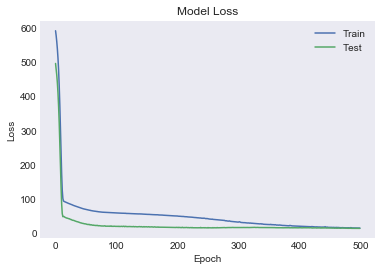

In [44]:
# Show visualization of training


plt.style.use(['seaborn-deep'])
plt.plot(housing.history['loss'])
plt.plot(housing.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [40]:
# Linear model of same data

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [48]:
# Accuracy comparison

print('Keras MSE:', (scores[1]))
print('LR MSE:', mean_squared_error(y_test, y_pred))

Keras MSE: 26.242987
LR MSE: 18.165510493496424


In [ ]:
# Regression still better for me! Wonder what I can improve

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- The number of nodes in your output layer should equal the number of classes you want to predict for Fashion-MNIST.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [73]:
##### Your Code Here #####

# import dataset
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

In [74]:
X_train.shape

(60000, 28, 28)

In [75]:
X_train[0].shape

(28, 28)

In [76]:
X_test.shape

(10000, 28, 28)

In [77]:
# reshape data

X_train = X_train.reshape(60000, 784) # 28 * 28 is 784
X_test = X_test.reshape(10000, 784)

# Make sure they are floats

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [78]:
# correct encoding for softmax

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [79]:
y_train[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [84]:
# create model

fmnist_model = Sequential()

# Input to hidden
fmnist_model.add(Dense(16, input_dim=784, activation='relu'))
# Hidden
fmnist_model.add(Dense(16))
fmnist_model.add(LeakyReLU(alpha=0.05))
# Hidden
fmnist_model.add(Dense(16, activation='relu'))
#Output
fmnist_model.add(Dense(10, activation='softmax'))

# Compile
fmnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                            'categorical_accuracy',
                            'cosine_proximity'])

fmnist_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                170       
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
_________________________________________________________________


In [85]:
fashion = fmnist_model.fit(X_train, y_train, batch_size=50000,
                           epochs=1000, validation_split=.1,
                           verbose=1)
scores = fmnist_model.evaluate(X_test, y_test)
print(f'{fmnist_model.metrics_names[1]}: {scores[1]*100}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/1000
54000/54000 [==============================] - 0s 9us/sample - loss: 102.7412 - acc: 0.1020 - categorical_accuracy: 0.1020 - cosine_proximity: 0.1024 - val_loss: 39.9393 - val_acc: 0.0887 - val_categorical_accuracy: 0.0887 - val_cosine_proximity: 0.0949
Epoch 2/1000
54000/54000 [==============================] - 0s 5us/sample - loss: 39.7398 - acc: 0.0911 - categorical_accuracy: 0.0911 - cosine_proximity: 0.0963 - val_loss: 33.1038 - val_acc: 0.0943 - val_categorical_accuracy: 0.0943 - val_cosine_proximity: 0.1000
Epoch 3/1000
54000/54000 [==============================] - 0s 5us/sample - loss: 32.8437 - acc: 0.1016 - categorical_accuracy: 0.1016 - cosine_proximity: 0.1067 - val_loss: 22.8623 - val_acc: 0.1560 - val_categorical_accuracy: 0.1560 - val_cosine_proximity: 0.1653
Epoch 4/1000
54000/54000 [==============================] - 0s 5us/sample - loss: 22.6678 - acc: 0.1609 - categorical_accuracy: 0.1609 - cosine_proximit

In [86]:
# wow 52 is pretty crappy, let me try again

fashion = fmnist_model.fit(X_train, y_train, batch_size=128,
                           epochs=20, validation_split=.1,
                           verbose=1)
scores = fmnist_model.evaluate(X_test, y_test)
print(f'{fmnist_model.metrics_names[1]}: {scores[1]*100}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 3s 47us/sample - loss: 1.1555 - acc: 0.5115 - categorical_accuracy: 0.5115 - cosine_proximity: 0.6338 - val_loss: 1.0803 - val_acc: 0.5370 - val_categorical_accuracy: 0.5370 - val_cosine_proximity: 0.6572
Epoch 2/20
54000/54000 [==============================] - 3s 49us/sample - loss: 1.0517 - acc: 0.5482 - categorical_accuracy: 0.5482 - cosine_proximity: 0.6639 - val_loss: 1.0337 - val_acc: 0.5648 - val_categorical_accuracy: 0.5648 - val_cosine_proximity: 0.6710
Epoch 3/20
54000/54000 [==============================] - 3s 48us/sample - loss: 1.0221 - acc: 0.5616 - categorical_accuracy: 0.5616 - cosine_proximity: 0.6739 - val_loss: 1.0159 - val_acc: 0.5768 - val_categorical_accuracy: 0.5768 - val_cosine_proximity: 0.6786
Epoch 4/20
54000/54000 [==============================] - 3s 49us/sample - loss: 1.0108 - acc: 0.5691 - categorical_accuracy: 0.5691 - cosine_proximity: 0.6778 - 

In [87]:
# alright 75 is better!

[Text(0, 0.5, ''), Text(0.5, 0, 'epochs'), Text(0.5, 1.0, 'Cosine Proximity')]

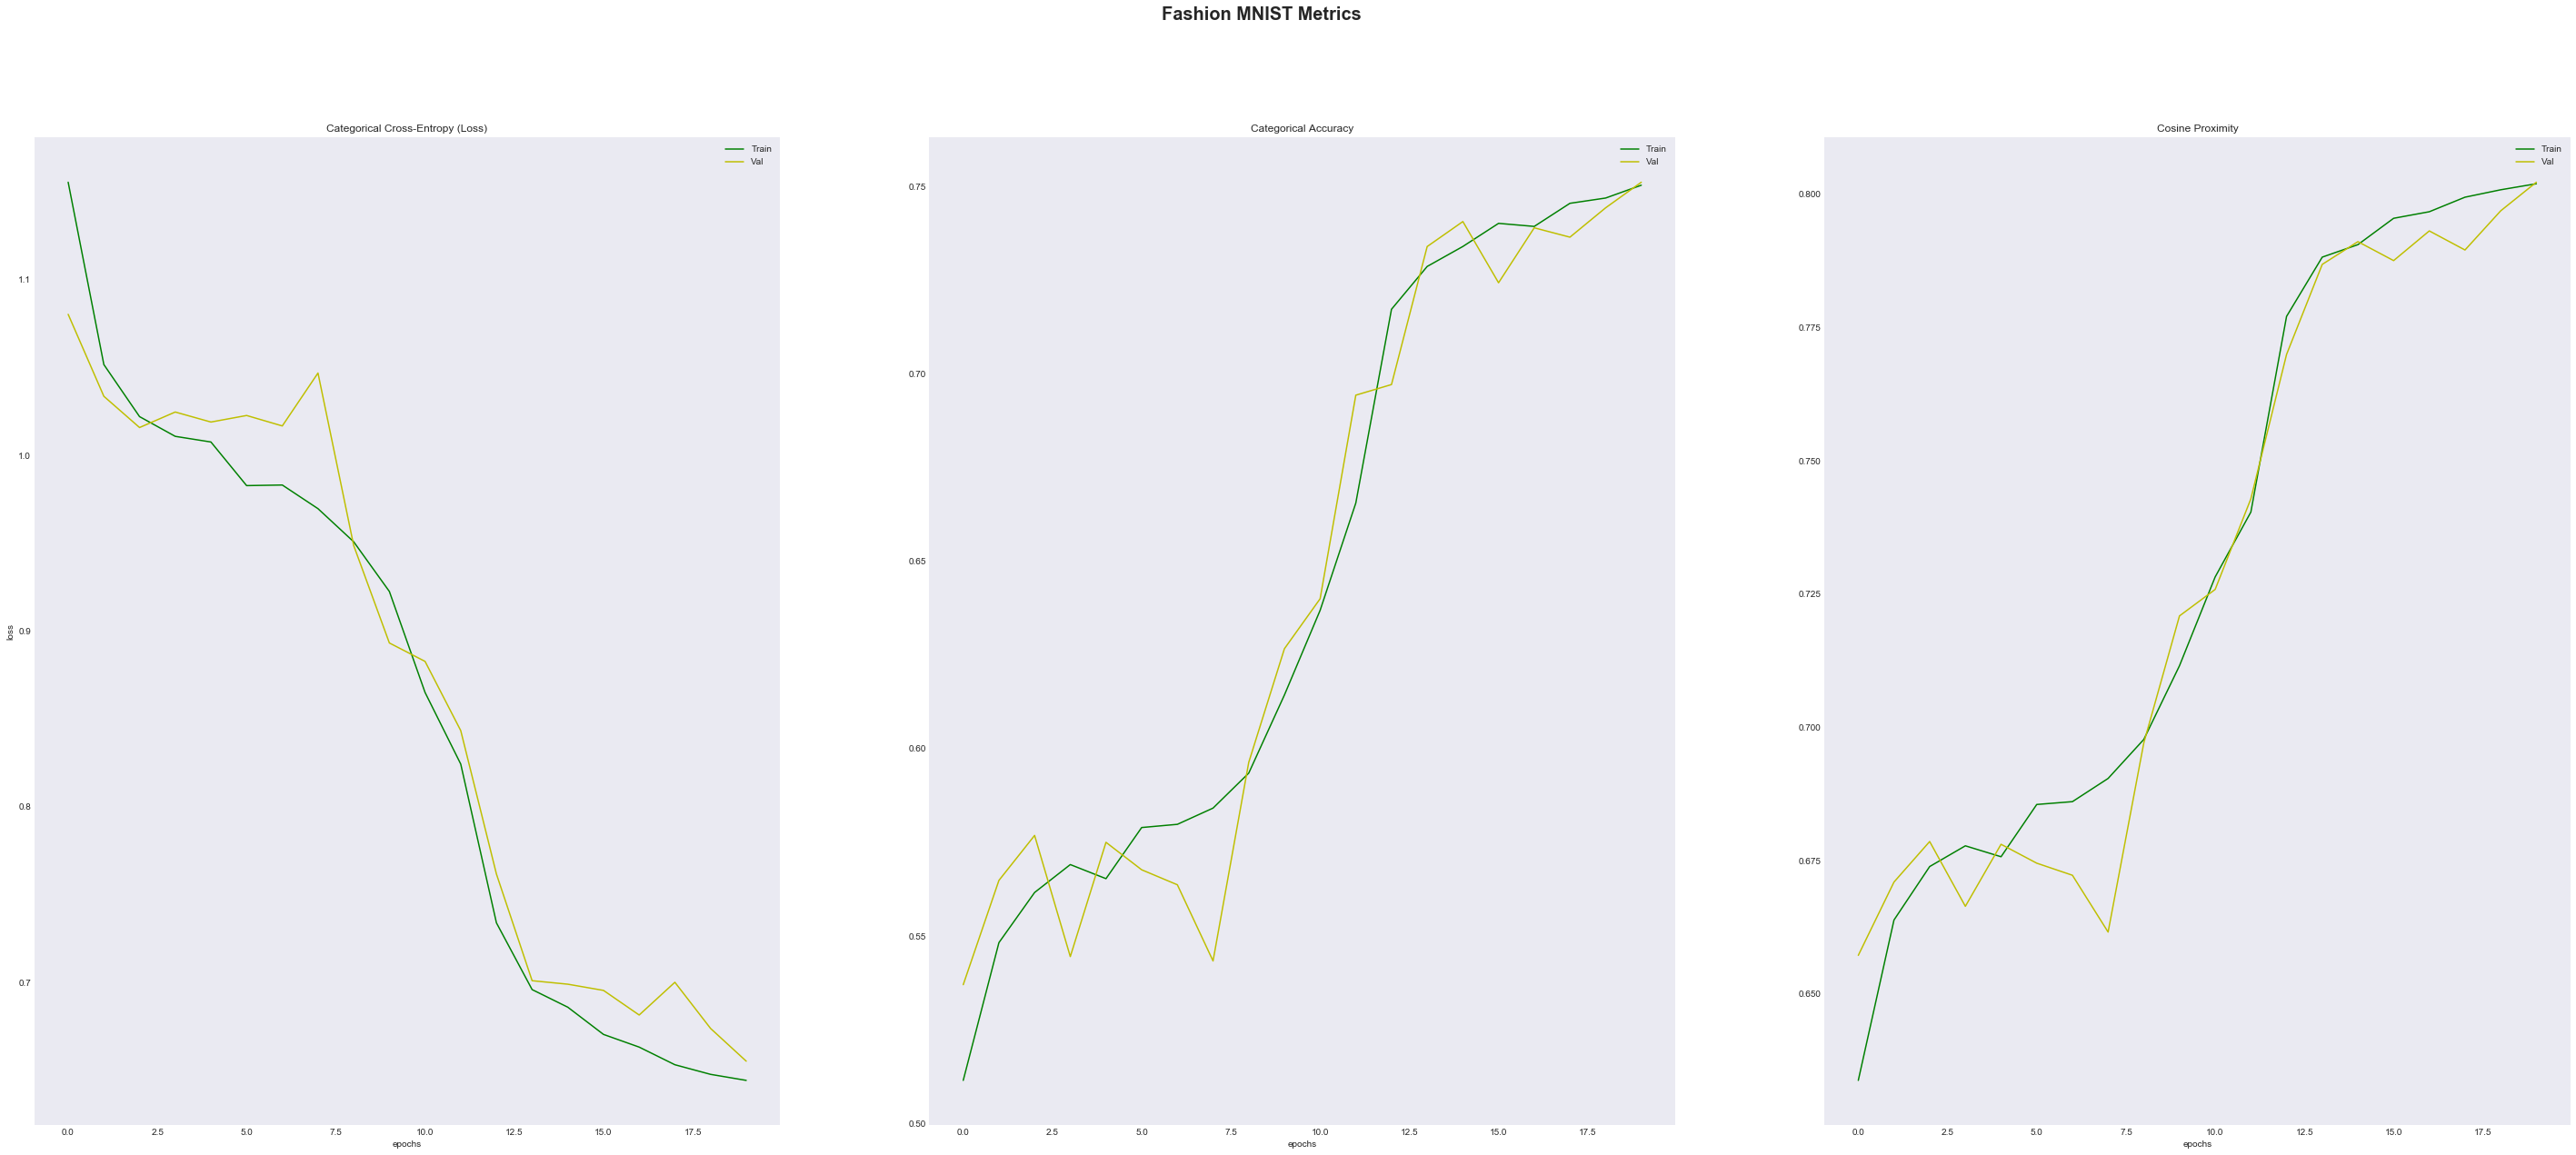

In [96]:
# Some visualizations

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(30,))
fig.suptitle('Fashion MNIST Metrics', fontsize=20, fontweight='bold')

ax1.plot(fashion.history['loss'], color= 'g', label='Train')
ax1.plot(fashion.history['val_loss'], color='y', label='Val')
ax1.legend()
ax1.set(title='Categorical Cross-Entropy (Loss)', xlabel='epochs', ylabel='loss')

ax2.plot(fashion.history['categorical_accuracy'], color='g', label='Train')
ax2.plot(fashion.history['val_categorical_accuracy'], color='y', label='Val')
ax2.legend()
ax2.set(title='Categorical Accuracy', xlabel='epochs', ylabel='')

ax3.plot(fashion.history['cosine_proximity'], color='g', label='Train')
ax3.plot(fashion.history['val_cosine_proximity'], color='y', label='Val')
ax3.legend()
ax3.set(title='Cosine Proximity', xlabel='epochs', ylabel='')

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.